In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
def read_csv_dataset(file_name):
    df = pd.read_csv(file_name)
    print('Formato do dataset: ',df.shape)
    print('Feature Engineering...')
    date_split = df['Month'].str.split('-').str
    df['Year'], df['Month'] = date_split
    m = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12, }
    df['Month'] = df['Month'].map(m)
    df.drop(df.columns[[3,4,5,6]], axis=1, inplace=True) #vou só ficar com as colunas 0,1,2,6
    df.drop(df.tail(2).index,inplace=True) #eliminar as duas últimas linhas com lixo
    df.dropna() #just to be sure
    df = df.astype(dtype=np.float64)
    #df["Year"] = df["Year"].astype(dtype=np.float64) #converter coluna do ano para floats
    print('Formato do dataset: ',df.shape)
    print(df.head())
    return df

In [3]:
#função load_data do lstm.py configurada para aceitar qualquer número de parametros
#o último atributo é que fica como label (resultado)
#stock é um dataframe do pandas (uma especie de dicionario + matriz)
#seq_len é o tamanho da janela a ser utilizada na serie temporal
def load_data(df_dados, janela):
    qt_atributos = len(df_dados.columns)
    tam_sequencia = janela + 1
    #converter dataframe para matriz (lista com lista de cada registo)
    #fazendo a divisão já em dados de teste e treino
    train_matrix =  df_dados.iloc[:24].values
    test_matrix = df_dados.iloc[24:].values
    #processamento dados de treino de acordo com o tamanho da janela
    train = []
    for i in range(len(train_matrix) - tam_sequencia): #numero de registos - tamanho da sequencia
        train.append(train_matrix[i: i + tam_sequencia])
    #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)
    train = np.array(train)
    #processamento dados de test de acordo com o tamanho da janela
    test = []
    for i in range(len(test_matrix) - tam_sequencia): #numero de registos - tamanho da sequencia
        test.append(test_matrix[i: i + tam_sequencia])
    #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)
    test = np.array(test)
    x_train = train[:, :-1] #menos um registo pois o ultimo registo é o registo a seguir à janela
    y_train = train[:, -1][:,2] #para ir buscar o atributo referente às sales para a lista dos labels
    x_test = test[:, :-1]
    y_test = test[:, -1][:,2]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], qt_atributos))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], qt_atributos))
    return [x_train,y_train,x_test,y_test]

In [4]:
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar '''
def build_model_tarraxo(janela):
    model = Sequential()
    model.add(LSTM(128, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.7))
    model.add(LSTM(64, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32, input_shape=(janela, 4), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [5]:
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar '''
def build_model_campos(janela):
    model = Sequential()
    model.add(LSTM(256, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, input_shape=(janela, 4), return_sequences=False))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [6]:
def print_model(model,fich):
 from keras.utils import plot_model
 plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

In [7]:
#imprime um grafico com os valores de teste e com as correspondentes tabela de previsões
def print_series_prediction(y_test,predic):
    diff=[]
    racio=[]
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        racio.append( (y_test[i]/predic[i])-1)
        diff.append( abs(y_test[i]- predic[i]))
        print('valor: %f ---> Previsão: %f Diff: %f Racio: %f' % (y_test[i],predic[i], diff[i],racio[i]))
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction') #este deu uma linha em branco
    plt.plot(diff,color='green', label='diff')
    plt.plot(racio,color='yellow', label='racio')
    plt.legend(loc='upper left')
    plt.show()

In [8]:
def normalization (df):
    print('Normalization...')
    min_max_scaler = MinMaxScaler()
    scaled_features = min_max_scaler.fit_transform(df)
    df = pd.DataFrame(scaled_features,columns=df.columns)
    print(df.head())
    return df

In [9]:
def pre_processing (df):
    print('Preprocessssing...')
    df['Month'] = df['Month'] / 100
    df['Advertising'] = df['Advertising'] / 100
    df['Sales'] = df['Sales'] / 100
    df['Year'] = df['Year'] / 100
    print(df.head())
    return df

In [10]:
'''
MSE- (Mean square error), RMSE- (root mean square error) –
o significado de RMSE depende do range da label. para o mesmo range menor é melhor.
'''
def sales_LSTM():
    df = read_csv_dataset("advertising-and-sales-data-36-co.csv")
    df = pre_processing(df)
    print("df", df.shape)
    janela = 2 #tamanho da Janela deslizante
    X_train, y_train, X_test, y_test = load_data(df, janela)
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    model = build_model_tarraxo(janela)
    model.fit(X_train, y_train, batch_size=4, epochs=200, validation_split=0.1, verbose=1)
    print_model(model,"lstm_model.png")
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print(model.metrics_names)
    p = model.predict(X_test)
    #para transformar uma matriz de uma coluna e n linhas em um np array de n elementos
    predic = np.squeeze(np.asarray(p))
    print_series_prediction(y_test,predic)

Formato do dataset:  (38, 7)
Feature Engineering...
Formato do dataset:  (36, 4)
   Month  Advertising  Sales  Year
0    1.0         12.0   15.0   1.0
1    2.0         20.5   16.0   1.0
2    3.0         21.0   18.0   1.0
3    4.0         15.5   27.0   1.0
4    5.0         15.3   21.0   1.0
Preprocessssing...
   Month  Advertising  Sales  Year
0   0.01        0.120   0.15  0.01
1   0.02        0.205   0.16  0.01
2   0.03        0.210   0.18  0.01
3   0.04        0.155   0.27  0.01
4   0.05        0.153   0.21  0.01
df (36, 4)
X_train (21, 2, 4)
y_train (21,)
X_test (9, 2, 4)
y_test (9,)
Train on 18 samples, validate on 3 samples
Epoch 1/200
18/18 [==============================] - 35s 2s/step - loss: 0.1477 - acc: 0.0000e+00 - val_loss: 0.0379 - val_acc: 0.0000e+00
Epoch 2/200
18/18 [==============================] - 1s 33ms/step - loss: 0.1433 - acc: 0.0000e+00 - val_loss: 0.0355 - val_acc: 0.0000e+00
Epoch 3/200
18/18 [==============================] - 1s 31ms/step - loss: 0.1387 - ac

18/18 [==============================] - 1s 28ms/step - loss: 0.0310 - acc: 0.0000e+00 - val_loss: 0.0449 - val_acc: 0.0000e+00
Epoch 55/200
18/18 [==============================] - 0s 21ms/step - loss: 0.0256 - acc: 0.0000e+00 - val_loss: 0.0448 - val_acc: 0.0000e+00
Epoch 56/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0246 - acc: 0.0000e+00 - val_loss: 0.0396 - val_acc: 0.0000e+00
Epoch 57/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0283 - acc: 0.0000e+00 - val_loss: 0.0343 - val_acc: 0.0000e+00
Epoch 58/200
18/18 [==============================] - 0s 23ms/step - loss: 0.0241 - acc: 0.0000e+00 - val_loss: 0.0326 - val_acc: 0.0000e+00
Epoch 59/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0277 - acc: 0.0000e+00 - val_loss: 0.0295 - val_acc: 0.0000e+00
Epoch 60/200
18/18 [==============================] - 0s 21ms/step - loss: 0.0277 - acc: 0.0000e+00 - val_loss: 0.0306 - val_acc: 0.0000e+00
Epoch 61/200
18/18 [======

18/18 [==============================] - 0s 24ms/step - loss: 0.0319 - acc: 0.0000e+00 - val_loss: 0.0248 - val_acc: 0.0000e+00
Epoch 113/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0261 - acc: 0.0000e+00 - val_loss: 0.0258 - val_acc: 0.0000e+00
Epoch 114/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0217 - acc: 0.0000e+00 - val_loss: 0.0290 - val_acc: 0.0000e+00
Epoch 115/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0242 - acc: 0.0000e+00 - val_loss: 0.0344 - val_acc: 0.0000e+00
Epoch 116/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0253 - acc: 0.0000e+00 - val_loss: 0.0379 - val_acc: 0.0000e+00
Epoch 117/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0238 - acc: 0.0000e+00 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 118/200
18/18 [==============================] - 0s 23ms/step - loss: 0.0235 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
Epoch 119/200
18/18 

Epoch 170/200
18/18 [==============================] - 1s 30ms/step - loss: 0.0230 - acc: 0.0000e+00 - val_loss: 0.0249 - val_acc: 0.0000e+00
Epoch 171/200
18/18 [==============================] - 1s 30ms/step - loss: 0.0241 - acc: 0.0000e+00 - val_loss: 0.0247 - val_acc: 0.0000e+00
Epoch 172/200
18/18 [==============================] - 1s 29ms/step - loss: 0.0234 - acc: 0.0000e+00 - val_loss: 0.0288 - val_acc: 0.0000e+00
Epoch 173/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0254 - acc: 0.0000e+00 - val_loss: 0.0322 - val_acc: 0.0000e+00
Epoch 174/200
18/18 [==============================] - 0s 23ms/step - loss: 0.0269 - acc: 0.0000e+00 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 175/200
18/18 [==============================] - 0s 23ms/step - loss: 0.0213 - acc: 0.0000e+00 - val_loss: 0.0436 - val_acc: 0.0000e+00
Epoch 176/200
18/18 [==============================] - 0s 22ms/step - loss: 0.0269 - acc: 0.0000e+00 - val_loss: 0.0426 - val_acc: 0.0000e+00
Epoch 

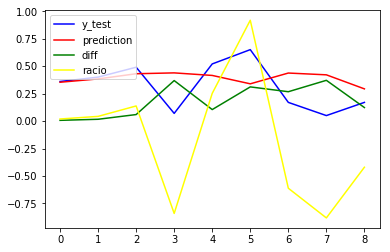

In [11]:
if __name__ == '__main__':
    sales_LSTM()